# Capstone Project: Region of Boom

## Table of Contents
- [Context](#Context)
    - [Information about the Stakeholder](#Information-about-the-Stakeholder)
        - [Project Idea Origin](#Project-Idea-Origin)
    - [Information about the Data](#Information-about-the-Data)
        - [Why We Looked for Better Data](#Why-We-Looked-for-Better-Data)
        - [Our New Data: Building Permit Surveys](#Our-New-Data:-Building-Permit-Surveys)
- [Wrangle](#Wrangle)
    - [Acquire](#Acquire)
        - [Functions](#Functions)
        - [Data Summary & Preliminary Exploration](#Data-Summary-&-Preliminary-Exploration)
    - [Prepare](#Prepare)
        - [Function](#Function)
        - [Returning to Preliminary Exploration](#Returning-to-Preliminary-Exploration)
- [Preprocessing & Exploration](#Preprocessing-&-Exploration)
    - [Creating Labels](#Creating-Labels)
        - [Two-Year Growth Rate](#Two-Year-Growth-Rate)
            - [Exploration](#Exploration)
                - [Hypothesis Testing with should_enter](#Hypothesis-Testing-with-should_enter)
        - [Clustering](#Clustering)
            - [Exploration](#Exploration)
                - [Hypothesis Testing with cluster](#Hypothesis-Testing-with-cluster)
    - [Conclusion](#Conclusion)
- [Exploration](#Exploration)
    - [Key-Takeaways](#Key-Takeaways)
- [Modeling](#Modeling)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [KNN](#KNN)
    - [Evaluate](#Evaluate)
    - [Conclusion](#Conclusion)
- [Prediction](#Prediction)
- [Conclusion](#Conclusion)
    - [Suggestions for improvement](#Suggestions-for-improvement)
        - [Adding markets that are likely to continue growing](#Adding-markets-that-are-likely-to-continue-growing)

In [1]:
# import data science libraries
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

---
# Introduction

Welcome to our final report on the 

## Information about the Stakeholder


### Project Idea Origin


## Information about the Data

The initial iteration of this project was performed using the United States Department of Housing and Urban Development (HUD) Federal Housing Administration (FHA) multifamily loan production data. After reaching an minimum viable product (MVP) with the aforementioned data, we as a team felt that the data we had was insufficient to adequately answer the research question that spawned our capstone project:

> How many high-density, multifamily structures are being built in the U.S. everyday?

Upon reaching an MVP the FHA data, we looked for a larger dataset to continue working on our project. The work done on the dataset we aquired for our second iteration, which we believe is more complete, is below. Our initial project can be found [here](https://nbviewer.jupyter.org/github/hud-capstone/capstone/blob/master/mvp_notebook.ipynb).

### Why We Looked for Other Data

For our capstone, we wanted to explore and model multifamily housing *construction* in the U.S. over time. The dataset we initially found was information on FHA multifamily mortgages over the past 15 years. As we explored the data, we recognized some problems that needed to be overcome:

1. Not all construction that happens in the U.S. uses a FHA backed mortgage. As a result, we could not gain any insights on construction behavior in the private sector using the FHA data.
2. 80% of the dataset was refinanced mortgages. There are many reasons to refinance a loan, but unpacking which of these refinances indicated refinancing a *construction* loan was out-of-scope for this project ([read more here](https://www.reonomy.com/blog/post/commercial-loan-refinance)). Ultimately, the activity that was of interest to our stakeholder was a minority of the dataset.  
3. After reshaping our data to make a single observation (a `city_state_year`), we were left with a small number of observations that provided us with continuous information for the time period. While imputation with zero values was a reasonable solution for observations lacking data, this created a new set of problems.
4. When imputing with zeros, our continuous variables ended up behaving like discrete variables because we had so many instances of just one or zero mortgages for a `city_state_year` observation.
    
### Our New Data: Building Permit Surveys

Using the United States Census Bureau Building Permit Survey data, we were able to gain more insights and create value for our stakeholder.

[United States Census Bureau Building Permits Survey](https://www.census.gov/construction/bps/): The main webpage where the data was sourced

[ASCII files by State, Metropolitan Statistical Area (MSA), County or Place](https://www2.census.gov/econ/bps/): The comma-separated text files aggregated based on various geographical areas

[MSA Folder](https://www2.census.gov/econ/bps/Metro/): We used data on the Metropolitan Statistical Area level of granularity

[ASCII MSA Documentation](https://www2.census.gov/econ/bps/Documentation/msaasc.pdf): Documentation of the original features found in the resultant DataFrame from `acquire_building_permits` function

Our data science pipeline and conclusions are below. Enjoy!

---
# Wrangle

All functions are stored in `wrangle.py`.

## Acquire

### Functions
- `acquire_building_permits` - This function acquires MSA building permit survey data from the U.S. Census Bureau
- `rename_building_permit_columns` - Renames columns from the original text files storing the data
    - **Note**: This function is called within `acquire_building_permits`

In [3]:
# storing data in df variable
df = wr.acquire_building_permits()

### Data Summary & Preliminary Exploration

In [4]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.
Currently, each observation is the estimated and reported annual building permit survey data by metropolitan area.
We will need to reshape our data for modeling.""")
df

Our DataFrame contains 8,382 observations and 29 features.
Currently, each observation is the estimated and reported annual building permit survey data by metropolitan area.
We will need to reshape our data for modeling.


,survey_date,csa_code,cbsa_code,moncov,cbsa_name,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,2019,104.0,10580.0,True,Albany-Schenectady-Troy NY,1120.0,1120.0,309397.0,20.0,40.0,7644.0,12.0,45.0,6074.0,48.0,665.0,60456.0,984.0,984.0,268946.0,18.0,36.0,6544.0,12.0,45.0,6074.0,34.0,580.0,56469.0
1,2019,430.0,48260.0,False,Weirton-Steubenville WV-OH,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,5782.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,999.0,10180.0,False,Abilene TX,354.0,354.0,72824.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0,353.0,353.0,72596.0,8.0,16.0,2093.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,566.0,49660.0,False,Youngstown-Warren-Boardman OH-PA,323.0,323.0,73182.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0,234.0,234.0,50054.0,2.0,4.0,407.0,1.0,3.0,467.0,0.0,0.0,0.0
4,2019,558.0,48700.0,False,Williamsport PA,66.0,66.0,16215.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,49.0,12095.0,6.0,12.0,1610.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8377,1997,6240.0,9999.0,False,Pine Bluff AR MSA,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0,100.0,100.0,4638.0,10.0,20.0,405.0,0.0,0.0,0.0,1.0,96.0,1826.0
8378,1997,6280.0,9999.0,False,Pittsburgh PA MSA,4432.0,4432.0,551173.0,66.0,132.0,9580.0,52.0,194.0,12291.0,102.0,1306.0,65021.0,3705.0,3705.0,481092.0,60.0,120.0,9251.0,45.0,173.0,12002.0,81.0,1111.0,56757.0
8379,1997,6320.0,9999.0,False,Pittsfield MA MSA,97.0,97.0,11578.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0,80.0,80.0,9447.0,3.0,6.0,342.0,0.0,0.0,0.0,1.0,120.0,5750.0
8380,1997,6340.0,9999.0,False,Pocatello ID MSA,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0,263.0,263.0,23778.0,8.0,16.0,870.0,20.0,80.0,3630.0,2.0,14.0,543.0


**Let's get some high-level information on our data**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8382 entries, 0 to 8381
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   survey_date                    8382 non-null   int64  
 1   csa_code                       8382 non-null   float64
 2   cbsa_code                      8382 non-null   float64
 3   moncov                         8382 non-null   bool   
 4   cbsa_name                      8382 non-null   object 
 5   one_unit_bldgs_est             8382 non-null   float64
 6   one_unit_units_est             8382 non-null   float64
 7   one_unit_value_est             8382 non-null   float64
 8   two_units_bldgs_est            8382 non-null   float64
 9   two_units_units_est            8382 non-null   float64
 10  two_units_value_est            8382 non-null   float64
 11  three_to_four_units_bldgs_est  8382 non-null   float64
 12  three_to_four_units_units_est  8382 non-null   f

---
**Let's take a look at the distribution of our data**

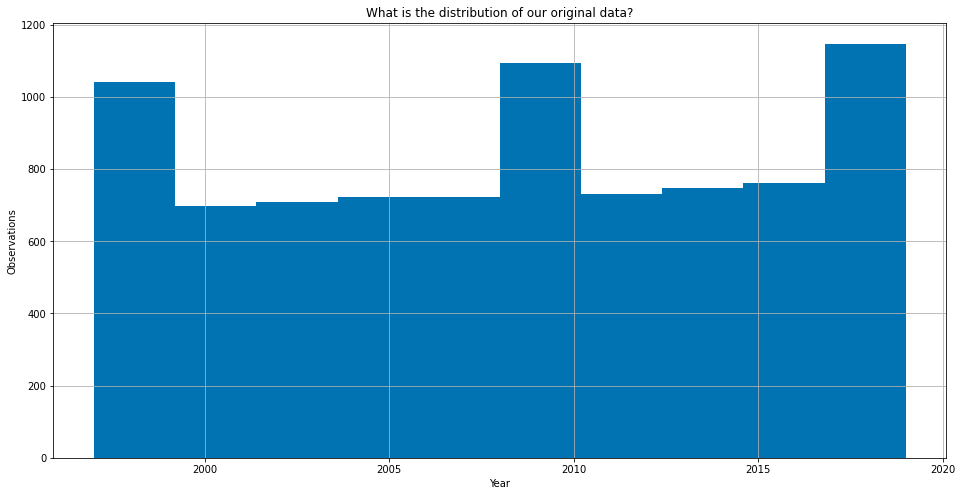

In [6]:
df.survey_date.hist()
plt.title("What is the distribution of our original data?")
plt.xlabel("Year")
plt.ylabel("Observations")
plt.show()

**Takeaway**: Looks like our data is relatively uniformly distributed with some outlier years.

---

**Let's take a look at the top 20 metro areas**

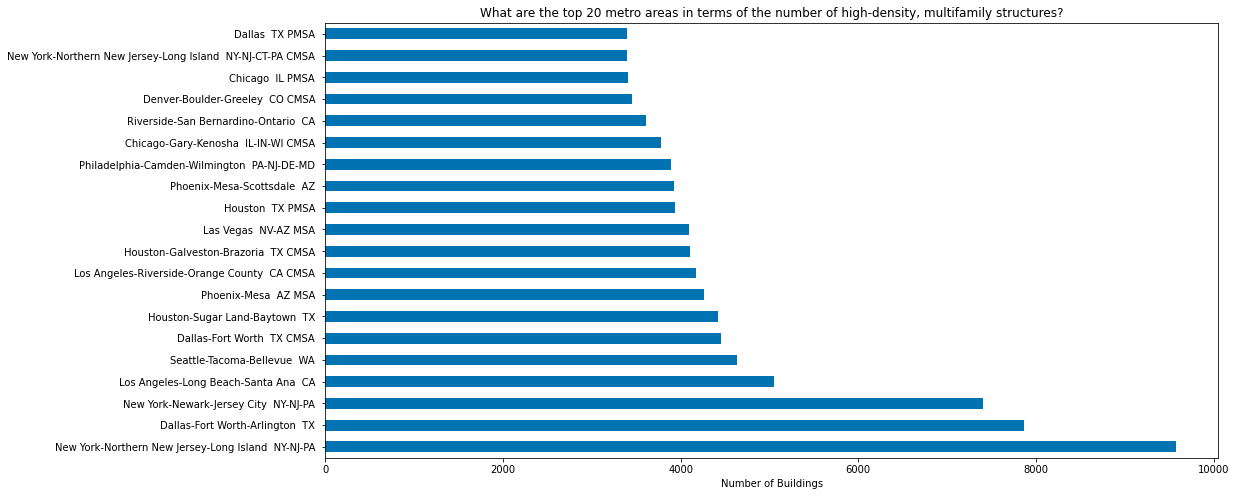

In [7]:
df.groupby("cbsa_name").five_or_more_units_bldgs_est.sum().sort_values(ascending=False
).nlargest(20).plot(kind="barh")
plt.title("What are the top 20 metro areas in terms of the number of high-density, multifamily structures?")
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()

**Takeaway**: Not surprisingly, the NYC metro area tops the charts. Another consideration is the fact that we will need to standardize these metro area names to get unique metro observations. Let's handle that now before we continue on in our exploration so that our insights are more valuable.

## Prepare

### Function
- `prep_building_permits` - This function creates some standardized the `major_city` and `major_state` features out of the `cbsa_name` feature from our inital DataFrame. Additionally, this function groups the `major_city`, `major_state`, and `survey_date` features together and summarizes all other quantitative features in the DataFrame.

In [8]:
df = wr.prep_building_permits(df)

In [9]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 8,269 observations and 30 features.


,major_city,major_state,survey_date,csa_code,cbsa_code,moncov,one_unit_bldgs_est,one_unit_units_est,one_unit_value_est,two_units_bldgs_est,two_units_units_est,two_units_value_est,three_to_four_units_bldgs_est,three_to_four_units_units_est,three_to_four_units_value_est,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est,one_unit_bldgs_rep,one_unit_units_rep,one_unit_value_rep,two_units_bldgs_rep,two_units_units_rep,two_units_value_rep,three_to_four_units_bldgs_rep,three_to_four_units_units_rep,three_to_four_units_value_rep,five_or_more_units_bldgs_rep,five_or_more_units_units_rep,five_or_more_units_value_rep
0,Abilene,TX,1997,40.0,9999.0,False,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0,215.0,215.0,25825.0,0.0,0.0,0.0,1.0,3.0,125.0,0.0,0.0,0.0
1,Abilene,TX,1998,40.0,9999.0,False,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,250.0,32745.0,2.0,4.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Abilene,TX,1999,40.0,9999.0,False,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,25372.0,3.0,6.0,382.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abilene,TX,2000,40.0,9999.0,False,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0,164.0,164.0,22306.0,9.0,18.0,1140.0,0.0,0.0,0.0,15.0,192.0,10200.0
4,Abilene,TX,2001,40.0,9999.0,False,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0,172.0,172.0,25539.0,28.0,56.0,3286.0,41.0,164.0,7631.0,13.0,192.0,6333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8264,Yuma,AZ,2015,999.0,49740.0,False,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0,765.0,765.0,117198.0,0.0,0.0,0.0,1.0,3.0,106.0,0.0,0.0,0.0
8265,Yuma,AZ,2016,999.0,49740.0,False,890.0,890.0,137493.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0,824.0,824.0,131881.0,0.0,0.0,0.0,2.0,7.0,712.0,0.0,0.0,0.0
8266,Yuma,AZ,2017,999.0,49740.0,False,1005.0,1005.0,163723.0,2.0,4.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0,993.0,993.0,161953.0,1.0,2.0,245.0,6.0,24.0,3118.0,8.0,68.0,8986.0
8267,Yuma,AZ,2018,999.0,49740.0,False,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,1011.0,1011.0,160289.0,2.0,4.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0


**Takeaway**: Now we have unique city, state, year observations for our data! Let's revisit that horizontal bar plot we saw earlier.

---

### Returning to Preliminary Exploration

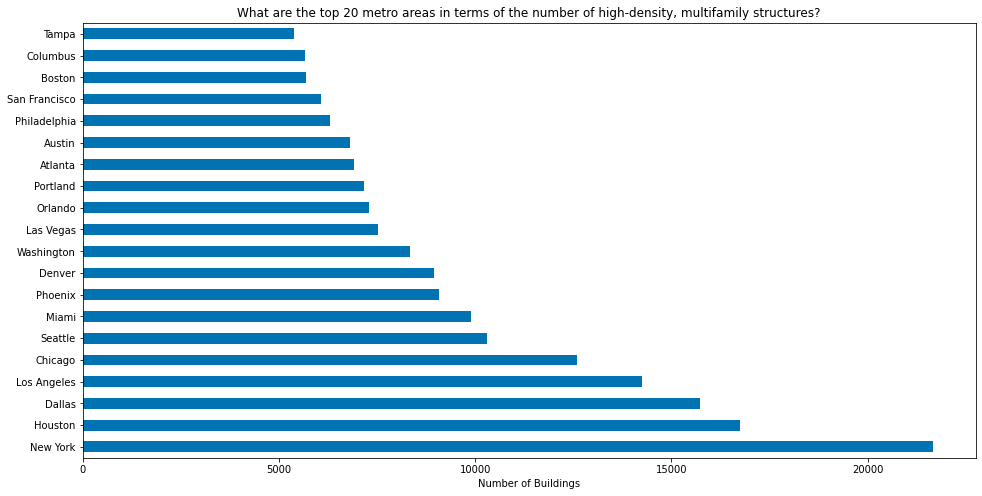

In [10]:
df.groupby("major_city").five_or_more_units_bldgs_est.sum().nlargest(20).plot(kind="barh")
plt.title("What are the top 20 metro areas in terms of the number of high-density, multifamily structures?")
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.show()

**Takeaways**: Much better! Looks like NYC is still top dog followed by Houston, Dallas, and LA.

---
**Let's peak at the distribution of the estimated high-density, multifamily building valuation**

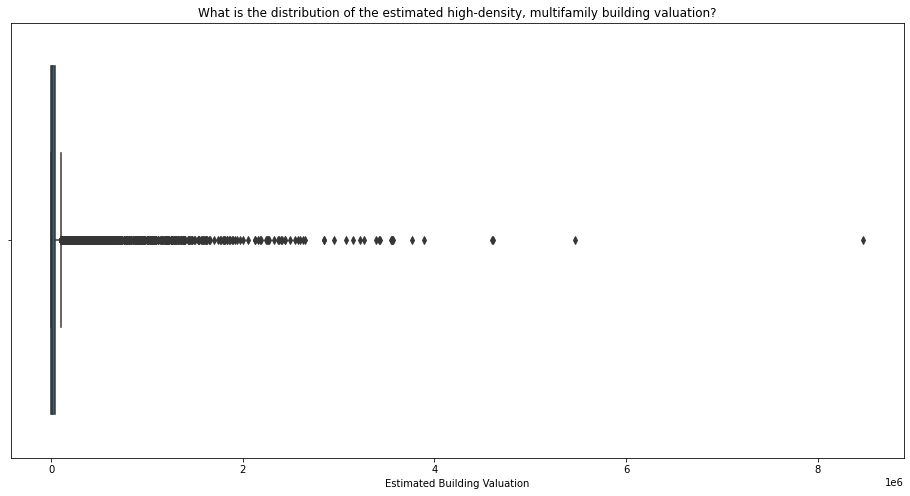

In [11]:
sns.boxplot(df.five_or_more_units_value_est)
plt.title("What is the distribution of the estimated high-density, multifamily building valuation?")
plt.xlabel("Estimated Building Valuation")
plt.show()

**Takeaways**: Wow! Our data is very right-skewed with a lot of upper outliers. Unfortunately, we cannot afford to remove the outliers in this dataset since we need as complete of a picture as possible to gain insights into the multifamily housing market. This will make statistical testing difficult.

---

Now that we have a decent grasp of our data, we need to restucture the dataset into a useable format for exploration and modeling. Let's do some preprocessing!

---
# Preprocessing & Exploration

In order to get our data into a useable format for meaningful exploration and subsequent modeling we decided to group the data by city and state for each year to get unique observations. Below is a brief summary of the functions found in the `preprocessing_permits.py` script which help to restructure our data into a useable format:

**Create Model DataFrame**
- `get_permits_model_df`: This function wrangles the data, selects only the features of relevance to our research (high-density, multifamily metrics), and gives those features more meaningful names.

**Feature Engineering**
- `calculate_avg_units_per_bldg`: This function calcuates the average number of units per building for an observation by dividing the total number of units by the total number of buildings.
- `calculate_value_per_bldg`: This function calcuates the average valuation per building for an observation by dividing the total valuation by the total number of buildings.
- `calculate_value_per_unit`: This function calcuates the average valuation per unit for an observation by dividing the total valuation by the total number of units.
- `calculate_city_state_high_density_bldgs_delta_pct`: This function calcuates the growth rate based on the total number of buildings for unique observations.
- `calculate_city_state_high_density_units_delta_pct`: This function calcuates the growth rate based on the total number of units for unique observations.
- `calculate_city_state_high_density_value_delta_pct`: This function calcuates the growth rate based on total valuation for unique observations.
- `calculate_evolution_index`: This function calculates the evolution index. Breifly, the evolution index is the measure of an observation's relative performance in terms of a growth rate compared to that of the total market growth year-over-year.
- `add_new_features`: This function calls all of the above feature engineering functions.

**Clustering**
- `create_clusters`: This function creates clusters using average units per building & evolution index.

**Label, Split, & Scale**
- `filter_top_cities_building_permits`: This function transforms the DataFrame such that the output returns cities with only continuously reported data, and cities where the observation had at least one high-density building for every year.
- `labeling_future_data`: This function labels a city_state_year observation as a market that should be entered based on the future two year growth rate of that observation.
- `split_data`: This function splits our data into train, validate, and test.
- `return_values`: This is a helper function used to update the scaled arrays and transform them into usable DataFrames (called within `min_max_scaler`).
- `min_max_scaler`: This is a helper function that scales the data.
- `prep_data_for_modeling_permits`: This function masks our DataFrame such that there are no null values for the relevant modeling features, creates an `observation_id` feature using the `city`, `state`, and `year` features, calls `split_data`, and calls `min_max_scaler`.

**Mother Function**
- `permits_preprocessing_mother_function`: This function wraps all of the functions documented here into one simple function.

---

Now let's use our functions to create labels, explore, and model.

---

In [12]:
df = pr.get_permits_model_df()
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 6 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value
0,Abilene,TX,1997,0.0,0.0,0.0
1,Abilene,TX,1998,0.0,0.0,0.0
2,Abilene,TX,1999,0.0,0.0,0.0
3,Abilene,TX,2000,15.0,192.0,10200000.0
4,Abilene,TX,2001,13.0,192.0,6333000.0


Now our DataFrame contains only unique combinations of the `city`, `state`, and `year` features with summarized metrics on estimated high-denisty, multifamily housing. However, we need some more meaningful features. Let's call our trusty `add_new_features` function on our `df` variable to help us out.

In [13]:
df = pr.add_new_features(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 8,269 observations & 15 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei
0,Abilene,TX,1997,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.054924e+10,NaN,NaN
1,Abilene,TX,1998,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.529787e+10,0.231085,NaN
2,Abilene,TX,1999,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.609590e+10,0.031545,NaN
3,Abilene,TX,2000,15.0,192.0,10200000.0,12.800000,680000.000000,53125.000,inf,inf,inf,2.742204e+10,0.050818,inf
4,Abilene,TX,2001,13.0,192.0,6333000.0,14.769231,487153.846154,32984.375,-0.133333,0.0,-0.379118,2.913103e+10,0.062322,0.584458


That's better! We have some very interesting feautures to both explore and help us create labels for our data.

---
## Creating Labels

Here we will document the various methods used to create labels for our data. First, we will explore the two-year growth rate labels.

### Two-Year Growth Rate

Real estate development is a long-term game. In order to identify potentially lucrative future markets for our stakeholder, we need label our data such that we are predicting the growth rate of a market two-years from now.

Before we get to the calculation, we need to filter our data such that we are only considering cities with 23 *consecutive* years worth of high-density, multifamily housing construction.

In [14]:
df = pr.filter_top_cities_building_permits(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 2,990 observations & 16 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY


This function is crucial for the accurate acessment of our data! We went from 8,000 observations to just under 3,000 when only considering cities with 23 consecutive years worth of high-density, multifamily housing construction.

Now we can press on with the two-year growth rate calculation.

In [15]:
df = pr.labeling_future_data(df)
print(f"""Our modeling DataFrame contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Our modeling DataFrame contains 2,990 observations & 21 features


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,0.300000,0.370041,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,-0.468085,-0.702574,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.300000,0.370041,0.435897,0.002124,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False


After calling `labeling_future_data` on our DataFrame, we gain some interesting features and a label derived from those features. Essentially, the `should_enter` feature labels our observations as markets to enter or not. A market qualifies as one to enter if the projected growth rate of either the quantity or valuation of high-density, multifamily structures exceeds the third quantile plus 1.5 times the interquartile range (Q3 + (IQR * 1.5)).

#### Exploration

##### Hypothesis Testing with `should_enter`

$H_0$: The mean valuation of high-density, multifamily structures for markets labeled to enter is the same as the population

$H_a$: The mean valuation of high-density, multifamily structures for markets labeled to enter is different from the population

In [16]:
alpha = .01

enter = df[df.should_enter == True].total_high_density_value

tstat, pvalue = stats.ttest_ind(enter, df.total_high_density_value.mean())

ex.get_stat_test_results(tstat, pvalue, alpha)

statistic = nan
  p-value = nan

Fail to reject null hypothesis


**Takeaway**: We fail to reject the null hypothesis. The mean valuation of high-density, multifamily structures for markets labeled to enter is not statistically different from the population. There may be other features that we uncover as drivers of whether a market is labeled to enter or not. For now, let's take a look at a quick visualization to demonstrate the statistical test we just conducted.

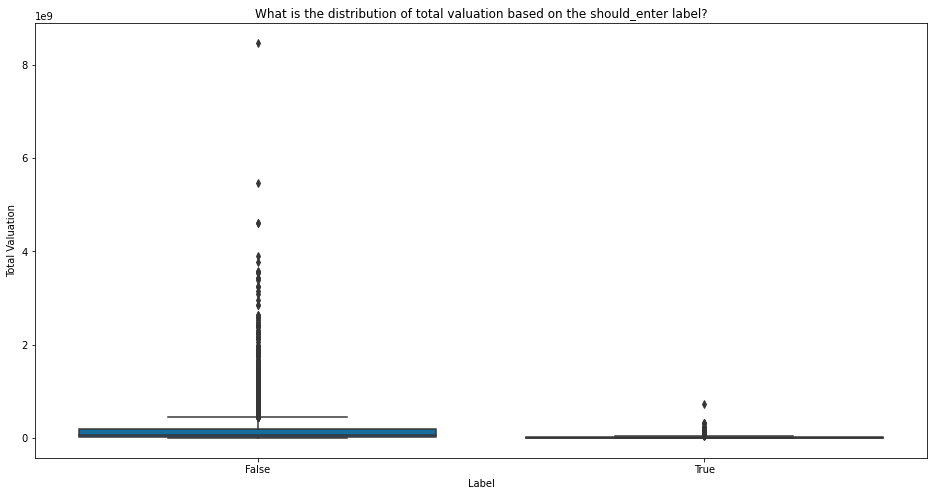

In [17]:
sns.boxplot(data=df, x="should_enter", y="total_high_density_value")
plt.title("What is the distribution of total valuation based on the should_enter label?")
plt.xlabel("Label")
plt.ylabel("Total Valuation")
plt.show()

**Takeaway**: If anything, this visual shows us that the *False* label in the should_enter feature may have a statically different mean from the population.

---

Next, we will do some clustering to create some labels.

---

### Clustering

By clustering, we can identify groups in our data that may not be readily apparent. Using our derived features we were able to create some valuable clusters that ultimately helped our team label the data and improve our model. Let's take a look as the process of creating our clusters.

First, lets ensure we are working with the proper data.

In [18]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,990 observations and 21 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,0.300000,0.370041,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,-0.468085,-0.702574,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.300000,0.370041,0.435897,0.002124,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False


Looks good! We have our cities with 23 consecutive years worth of high-density, multifamily housing construction, and the labels created using the projected growth rates. Now's lets call our `create_clusters` function on our DataFrame, and assess our clusters.

In [19]:
df, kmeans, centroids, scaler, scaled_ei_threshold_value, X = pr.create_clusters(df)
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 22 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,1.200626,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,-1.118050,Albany_NY,0.300000,0.370041,0.435897,0.002124,False,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,-0.655825,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,0.503915,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,0.146820,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5


The first thing I would like to draw attention to is the fact that we lost 130 observations when we call `create_clusters` on our DataFrame. This is due to the fact that our clusters are created in part by using the evolution index (`ei`) which, as a reminder, is the market growth rate relative to the population growth rate. So if there is no prior year observation to compare the growth of a market or the population to, *null values* will be created when the calculation is run for each of the earliest year observations (1997) for every unique combination of a city and state in our DataFrame. Given this understanding, we need to remove any observations from our DataFrame where there are null values in order for our K-means clustering algorithm to work properly. Thus, we remove 130 observations where the year is equal to 1997 as there is no year-over-year growth rate calculation for those observations.

Now let's take a look at the other objects that are unpacked when we call `create_clusters`. First, `kmeans`.

In [20]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

This object is merely the model object used to cluster our data. We can see here that there are 6 clusters created as the `n_clusters` parameter is set to 6.

"Well, how did we arrive at 6 clusters?", you may be asking yourself. Great question, let me show you!

First, let's take a look at the features we used to cluster stored in the `X` variable.

In [21]:
# scaled features from create_clusters function
X.head()

,avg_units_per_bldg,ei
1,0.499727,1.200626
2,-0.493115,-1.118050
3,-0.398138,-0.655825
4,-1.307457,0.503915
5,-1.049695,0.146820


You may notice that these features are not that values you may have expected to see. This is because our features have been scaled. Let's take a look at the `scaler` object created when unpacking our `create_clusters` function.

In [22]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

We are using a `PowerTransformer` scaler in order to make our features more Gaussian-like (normally distributed). This scaler helps reduce the [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) of our data.

Now that we have scaled features, we can pass them into our trusty `plot_inertia` function in order to determine the appropriate number of clusters for our data.

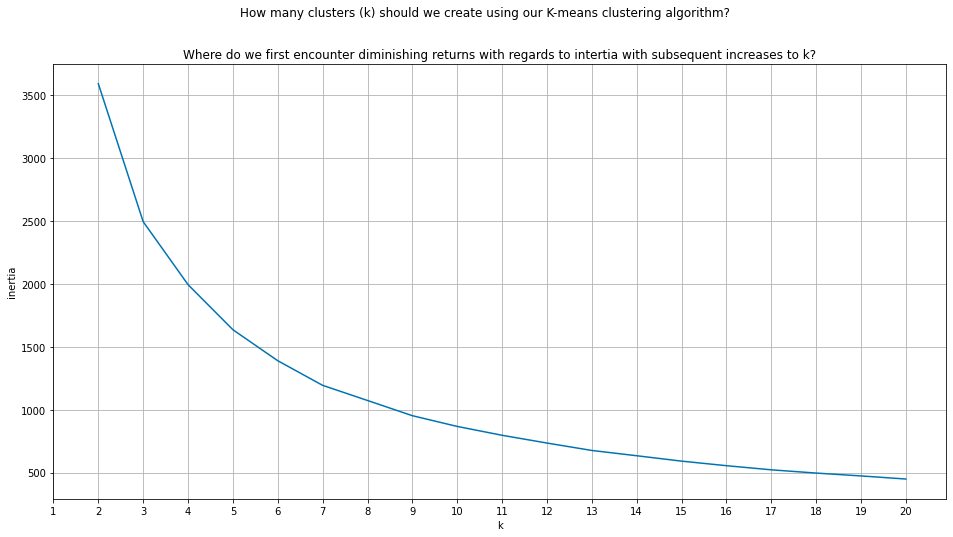

In [23]:
ex.plot_inertia(X)

Before interpreting the plot above, let's briefly define a couple terms as they relate to clustering.

> **centroid** - one of the cluster centers in K-means clustering

> **inertia** - sum of the squared distances from each point to it's assigned centroid

Essentially, inertia helps us define how many clusters should be created with K-means by telling us where the relative distance to the centroid for each point in a cluster is the smallest. For our analysis, it is important to create the minimum necessary clusters so that we are able to properly identify the differentiating characteristics of each cluster.

So, getting back to interpreting the plot above. The case for the point at which we first encounter diminishing returns with each subsequent increase in k could be made for either a k of 6 or 7. We chose to create 6 clusters according to the inertia plot above.

Finally, we will use the two remaining objects created when unpacking the `create_clusters` function by calling `visualize_clusters`.

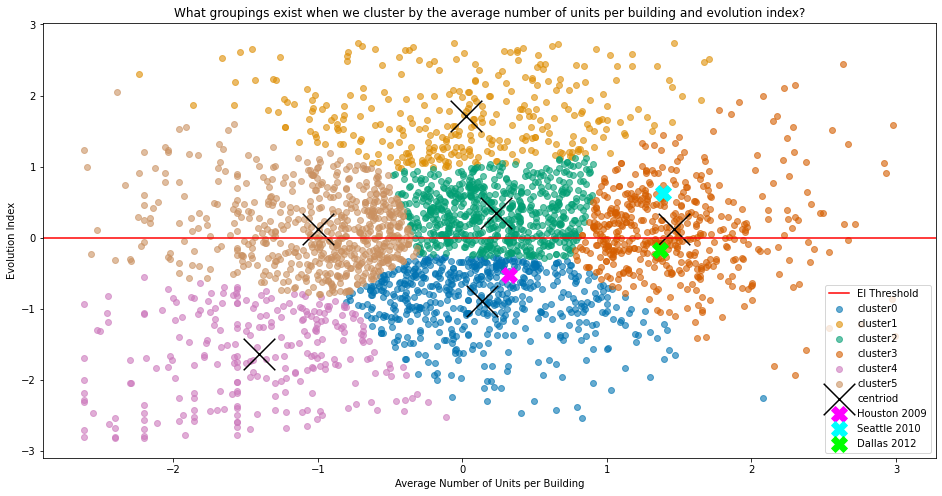

In [24]:
ex.visualize_clusters(df, centroids, scaled_ei_threshold_value)

It's important to reiterate that the features used to cluster are **scaled**. Why is this important? Well, by using the `PowerTransformer` scaler we transform our clustering features such that the distribution of the values in the features is normalized. Meaning, the 0 values in the axes of the plot shown above are the mean values of the respective features. For the average number of units per building, this is not so difficult to interpret. However, when considering the evolution index, interpretation becomes more challenging. For simplicity's sake, the 0 value on the y-axis is equivalent to an unscaled evolution index of 1 where a particular market is growing at the same rate as the population.

Okay, now let's interpret our scatterplot of the clusters. Below is a brief description of the characteristics of each cluster:

- `cluster0` - underperforming markets building an average number of units per building
- `cluster1` - markets outpacing the population building an average number of units per building
- `cluster2` - mixed growth markets building an average number of units per building
- `cluster3` - mixed growth markets building a high number of units per building
- `cluster4` - underperforming markets building a low number of units per building
- `cluster5` - mixed growth markets building a low number of units per building

Now, let's focus on the utility of these clusters.

If we are thinking like the stakeholder, we want to reap the profits of being established in a market that is growing or outpacing the greater U.S. housing market. Again, real estate development is a long-term game. Thus, we need to recommend markets that are likely to see a future movement into profitable clusters. How do we determine this?

#### Exploration

Let's take a random sample from each cluster and plot the trajectory of that market over time to see if we can identify common patterns (or movement between clusters) that would indicate a future profitable multifamily housing market.

First, we need to ensure we're working with the proper data

In [25]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 22 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,0.499727,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,1.200626,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1
2,Albany,NY,1999,39.0,515.0,24484000.0,-0.493115,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,-1.118050,Albany_NY,0.300000,0.370041,0.435897,0.002124,False,0
3,Albany,NY,2000,25.0,346.0,16130000.0,-0.398138,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,-0.655825,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False,0
4,Albany,NY,2001,56.0,502.0,24536000.0,-1.307457,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,0.503915,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5
5,Albany,NY,2002,47.0,475.0,29634000.0,-1.049695,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,0.146820,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5


Look's correct! We have our scaled features (`avg_units_per_bldg` and `ei`) and our clusters in our DataFrame.

Now, we need to *unscale* our clustering features so that the exploration done with them is more meaningful.

Let's ensure the scaler object is what we think it is.

In [26]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

Check. Now, let's use it.

In [27]:
# unscaling features
df[["avg_units_per_bldg", "ei"]] = scaler.inverse_transform(df[["avg_units_per_bldg", "ei"]])

In [28]:
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df.head()

Our DataFrame contains 2,860 observations and 22 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,-0.468085,-0.702574,False,1
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.300000,0.370041,0.435897,0.002124,False,0
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,-0.468085,-0.702574,0.880000,0.837198,False,0
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,0.435897,0.002124,-0.214286,0.539167,False,5
5,Albany,NY,2002,47.0,475.0,29634000.0,10.106383,6.305106e+05,62387.368421,-0.160714,-0.053785,0.207776,3.169504e+10,0.088016,1.110072,Albany_NY,0.880000,0.837198,0.297872,0.825639,False,5


We see in the DataFrame above that our clustering features have returned to their original, unscaled values. This will make the exploration process more explicit and interpretable.

Now, let's press on with the exploration of a random sample from each cluster.

In [29]:
# cluster 0 sample
df[(df.city == "Atlanta") & (df.state == "GA") & (df.year == 2009)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
127,Atlanta,GA,2009,36.0,994.0,105936000.0,27.611111,2.942667e+06,106575.452716,-0.777778,-0.859723,-0.844285,1.005604e+10,-0.608193,0.397428,Atlanta_GA,-0.902439,-0.913938,1.305556,0.907151,False,0


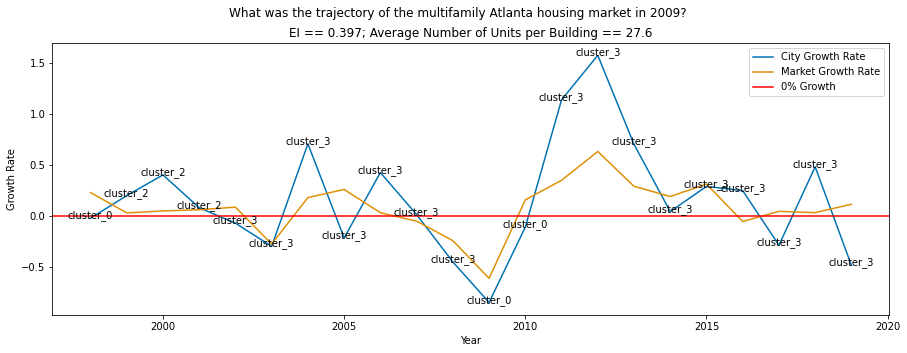

In [30]:
ex.growth_rate_line_plot(df, "Atlanta", 2009)

**Takeaways**:

In [31]:
# cluster 1 sample
df[(df.city == "Colorado Springs") & (df.state == "CO") & (df.year == 2010)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
680,Colorado Springs,CO,2010,2.0,77.0,6441000.0,38.5,3220500.0,83649.350649,1.0,8.625,7.101887,1.165572e+10,0.159076,6.989951,Colorado Springs_CO,-0.875,-0.88314,13.5,10.597268,True,1


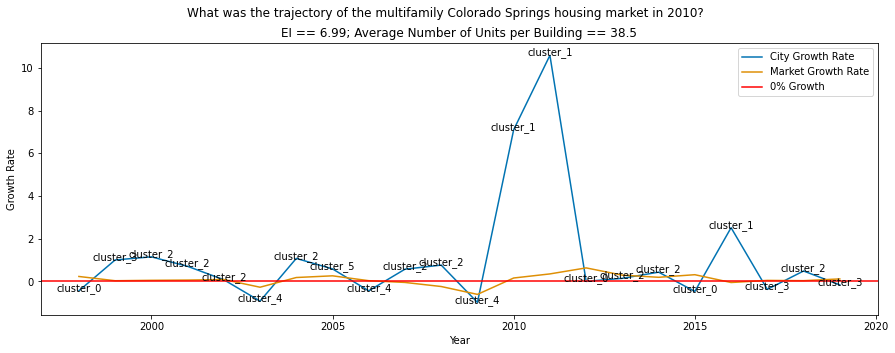

In [32]:
ex.growth_rate_line_plot(df, "Colorado Springs", 2010)

**Takeaways**:

In [33]:
# cluster 2 sample
df[(df.city == "Dallas") & (df.state == "TX") & (df.year == 2010)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
772,Dallas,TX,2010,203.0,4990.0,479537000.0,24.581281,2.362251e+06,96099.599198,-0.132479,-0.158942,-0.020824,1.165572e+10,0.159076,0.84479,Dallas_TX,-0.657673,-0.599501,1.246305,1.472987,False,2


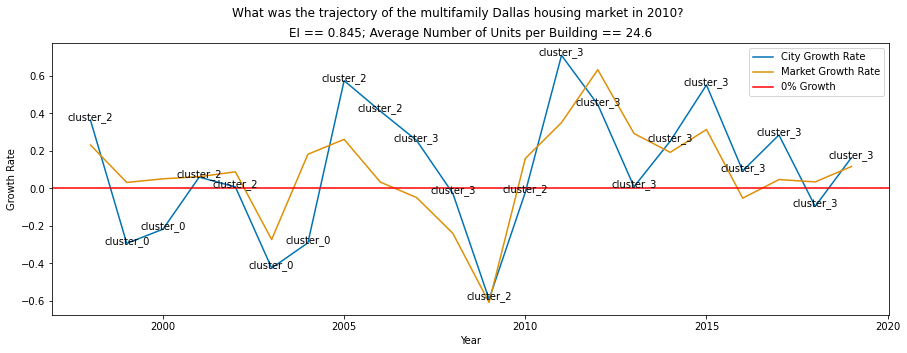

In [34]:
ex.growth_rate_line_plot(df, "Dallas", 2010)

**Takeaways**:

In [35]:
# cluster 3 sample
df[(df.city == "Spokane") & (df.state == "WA") & (df.year == 2011)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
2613,Spokane,WA,2011,32.0,981.0,90632000.0,30.65625,2832250.0,92387.359837,-0.135135,0.513889,0.451227,1.574184e+10,0.350568,1.074531,Spokane_WA,-0.058824,0.419563,-0.5,-0.740235,False,3


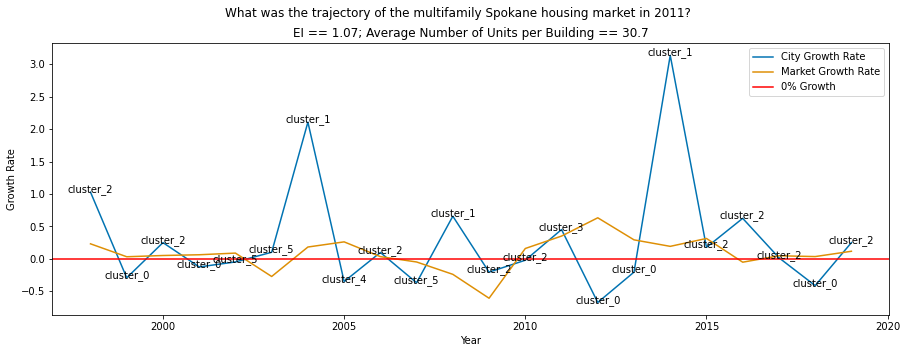

In [36]:
ex.growth_rate_line_plot(df, "Spokane", 2011)

**Takeaways**:

In [37]:
# cluster 4 sample
df[(df.city == "Lubbock") & (df.state == "TX") & (df.year == 2018)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1654,Lubbock,TX,2018,5.0,69.0,7049000.0,13.8,1409800.0,102159.42029,-0.951923,-0.909922,-0.916295,5.336251e+10,0.034393,0.080922,Lubbock_TX,-0.932432,-0.949683,NaN,NaN,False,4


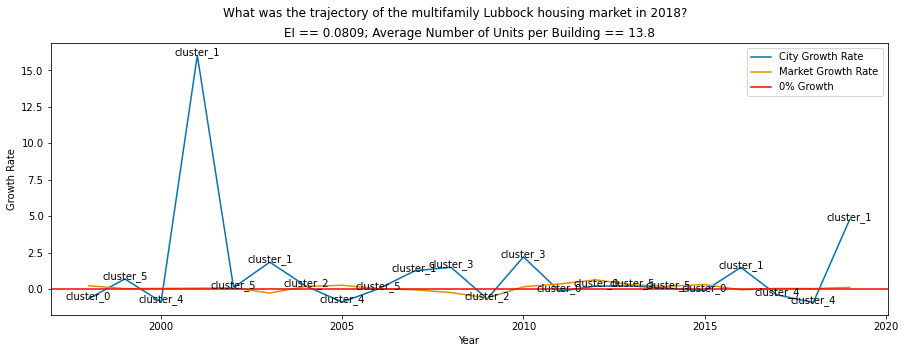

In [38]:
ex.growth_rate_line_plot(df, "Lubbock", 2018)

**Takeaways**:

In [39]:
# cluster 5 sample
df[(df.city == "Naples") & (df.state == "FL") & (df.year == 2007)]

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,bldgs_two_yr_growth_rate,value_two_yr_growth_rate,future_bldgs_two_yr_growth_rate,future_value_two_yr_growth_rate,should_enter,cluster
1850,Naples,FL,2007,75.0,829.0,208379000.0,11.053333,2.778387e+06,251361.881785,-0.184783,-0.189638,-0.078756,3.375194e+10,-0.049083,0.968795,Naples_FL,-0.496644,-0.44389,-0.84,-0.839826,False,5


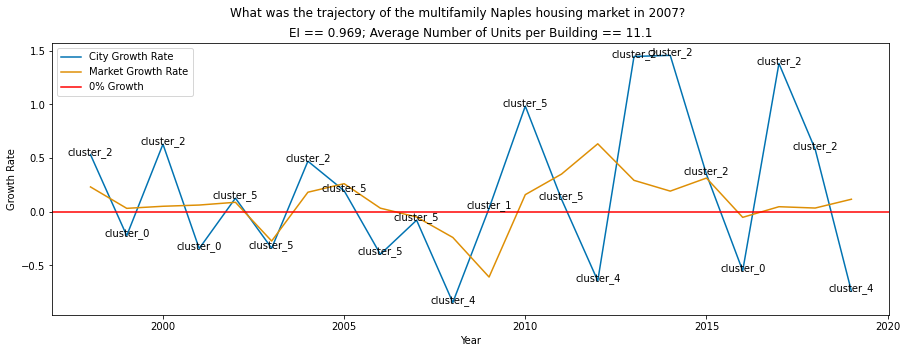

In [40]:
ex.growth_rate_line_plot(df, "Naples", 2007)

**Takeaways**:

##### Hypothesis Testing with `cluster`

Finally, let's do some hypothesis testing with our clusters based on some of the assumptions we have fromulated in our exploration process.

In [ ]:
# How many observation per cluster?

df.groupby("cluster").city.count().sort_values()

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="city_state_high_density_value_delta_pct")
plt.title("Are there any difference in value between the clusters?")

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="market_volume")
plt.title("Are there any difference in value between the clusters?")

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x="cluster", y="value_per_bldg")

## Conclusion

* It seems that the best markets are the ones in cluster_3, however, we need to be able to predict what observations will be in these markets two years before that happens. 
* We know that cluster_0 and cluster_4 are usually the underperforming markets, and usually market will transition from a low to a high. If we can predict those patterns, we can train the model.

---

In [ ]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our modeling DataFrame now contains {df.shape[0]:,} observations & {df.shape[1]} features""")
df.head()

Now that we have some useful labels, let's explore our data.

---

# Exploration

In [ ]:
f = plt.figure(figsize=(25,20))
continuous_data = df.select_dtypes(include=["int", "float"])

for count, element in enumerate(continuous_data):
    f.add_subplot(4,5, count+1)
    sns.barplot(data=df, x="should_enter", y=element, ci=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Key-Takeaways

From the graph above, we see that there are ceirtain numerical features that actually differ greatly by the different target variables. 

We predict the the following variables will likely lead to the most effective model, because they show a big difference in overall value when comparing the target variables:

* `ei_x`
* `avg_units_per_bldg_x`
* `cluster`
* `market_volume_delta_pct`
* `total_high_density_value`

On the otherhand, we expect that the following variables wouldn't work well for modeling, because there is no distinct value difference:

* `avg_units_per_building`
* `value_per_unit`
* `value_per_building`
* `marvel_value`




-----

# Modeling

We will be using classification algorithms to predict what markets will be hot as of 2020/2021. This will help us create recommendations for the future, so that we know what market's will be worth investing resources and labor in, and what martek's are worth ignoring.

We will be likely using the following features for modeling:

```python
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "market_volume_delta_pct", "total_high_density_value"]
```

Our target variable (the variable we are trying to predict, will be:

```python
label_feature = "should_enter"
```

In this case, our positive case will be `should_enter_market`. 


When looking at our confusion matrix, and all of it's possible outcomes, it would likely look as follows:

| Matrix | Actual Positive | Actual Negative |
|--------|-----------------|-----------------|
| Predicted Positive | `enter_market` | predicted `not_enter_market`, but really it was a hot market and a missed opportunity | 
| Predicted Negative | predicted `enter_market`, but really it was a cold market, and not worth investing | `not_enter_market`


Traditionally, for a project like this one, we would have focus on reducing the number of `False_Positives`, because it would be far more expensive to the stakeholder if we predicted a city was going to be hot, they spend time and money, and their investment is not returned. However, because TestFit's business strategy and software deployment are all done online, with very little investment needed for traveling. This means that actually investing in a city is not costly at all. As such, we will optimize our models to reduce the number of `False_Negtives`, because we want to make sure we are not missing any potential markets that can be considered `hot markets` in 2020 and 2021.

Given that we have a low number of `positive` labels in our data, we will have to do something called **Oversampling**. This is a practice use in the field to basically help the predictive model by calling attention to the postiive labels and their patterns. We will create duplicate positive values, so that the model becomes more effective at predicting these values. Initially, about 7% of our data had a positive label. After oversampling, we have increased the positive value to be ~25% of the total population.

## Decision Tree

In [ ]:
features_for_modeling = ["ei_x", "avg_units_per_bldg_x", "cluster", "market_volume_delta_pct", "total_high_density_value"]
label_feature = "should_enter"

In [ ]:
train_scaled, validate_scaled, test_scaled, y_train, y_validate, y_test = pr.permits_preprocessing_mother_function(modeling=True, features_for_modeling=features_for_modeling, label_feature=label_feature)

In [ ]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})
recall_value = "True"

In [ ]:
mo.run_clf_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

In [ ]:
clf, y_pred = mo.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [ ]:
accuracy_score, matrix, report = mo.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
mo.clf_feature_importances(clf, train_scaled)

Interestingly, it seems that when it comes to decision tree, the `evolution_index` is actually the most indicative feature, along side the change in number of mortgage's approved. It appears that `market_volume_delta_pct` and `total_high_density_value` are actually not that useful for decision tree.

## Random Forest

In [ ]:
mo.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

In [ ]:
rf, y_pred = mo.run_rf(train_scaled, y_train, 1, 3)
predictions["random_forest"] = y_pred

In [ ]:
accuracy_score, matrix, report = mo.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
mo.rf_feature_importance(rf, train_scaled)

Similarly, for random forest, the `evolution_index` is the most influencial feature, along with the clusters. 

## KNN

In [ ]:
mo.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, max_range=15)

In [ ]:
knn, y_pred = mo.run_knn(train_scaled, y_train, 2)
predictions["knn"] = y_pred

In [ ]:
accuracy_score, matrix, report = mo.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

In [ ]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["recall"]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = mo.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report[recall_value].loc["precision"]:.2f}')

## Evaluate

The best performing model is the KNN. It certainly performs better than the rest of the models, and much better than the baseline, meaning that in this case we definitively recommend using a model.

We will evaluate the KNN model with a `K_neighbore` of 1.

In [ ]:
knn, y_pred = mo.run_knn(train_scaled, y_train, 1)

In [ ]:
y_pred = knn.predict(test_scaled)

In [ ]:
accuracy_score, matrix, report = mo.accuracy_report(knn, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

## Conclusion

We see that KNN achieves a 91% accuracy and a 92% recall_score on test data. This is a really strong model, and we have confidence that we can use it to predict markets that Testfit should enter in 2020 and 2021, given that they are likely going to increase in value over the next two years. 

In the end, we do reject our null hypothesis, and can confidently say that `Evolution_index`, `avg_units_per_building`, `market_volume_growth` and `total_high_density_value` are good features to use for modeling, as they can help us understand and evaluate how a city might be peforming, especially in comparison to the rest of the country. The clusters have also been invaluable, as not only did they helped create our labels, but they also provide valuable information when it comes to modeling.

----

# Prediction

As part of our deliverables, it is important for our stakeholder that we can come up with a series of recommendations on which markets they should enter in 2020 and 2021. Because of Testfit's business model, they realistically need to enter a market 2 or 3 years before the market actually picks up, as their software is most useful when companies are in the planning stages and trying to secure loans. As such, we need to predict not what market's will be hot in 2020, but rather predict what markets will be hot in 2022 or 2023. 

We will average the data from 2018 and 2019 to create values for 2020 and 2021. Using the K-means cluster we fitted during the exploration, we can create a new cluster prediction on the aggregated values, which we can use for modeling. 

Once the data is scaled and clustered, we can use our KNN model to create a prediction on which cities will be Testgit should enter in 2020 and 2021.

In [ ]:
df = mo.prep_prediction_data(centroids)

In [ ]:
features_for_predicting = ["ei_x", "avg_units_per_bldg_x", "cluster", "market_volume_delta_pct"]

In [ ]:
# df = df.merge(centroids, how="left", left_on="cluster", right_on=centroids.index)

In [ ]:
df

In [ ]:
predictions = mo.create_predictions_df(df, kmeans, knn)
predictions

In [ ]:
print(f"Out of 130 cities, we recommend entering the following {predictions[predictions.label].shape[0]} markets")
predictions[predictions.label]

In [ ]:
# predictions.to_csv("predictions.csv")

In [ ]:
print("Markets with greatest return on investment")
print("-------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 0) | (predictions.cluster == 4))].city_state.to_string(index=False))

print("")
print("High density markets with potential for growth")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 5) | (predictions.cluster == 2))].city_state.to_string(index=False))

print("")
print("Markets already hot")
print("------------------")
print(predictions[(predictions.label) & ((predictions.cluster == 3) | (predictions.cluster == 1))].city_state.to_string(index=False))

# Conclusion

The model has recommended 43 cities to enter in 2020 and 2021. Again, these are not markets that are considered "hot" right now, but rather they are markets that will likely increase in value and activity over the next two to three years, so 2020 and 2021 would be the optimal time to enter the market, as developers and cities begin to work on granting permits and securing funding for new constructions.

We have further broken the recommendations into three groups, to further help with decision making. The first group are markets that are currently performing well below the rest of the market, and have low density populations. These are the markets that are best poised to quickly grow, and as such we highly recommend prioritizing these markets. 

The second group is markets that already likely have higher density (higher avg of units per building), however, they are also investing less loans than the rest of the market. These markets will likely also see a huge a surge in growth as well, and are still an opportunity that Testfit should take advantage of. 

The last group is the markets that are currently performing above the rest of the market, and are likely to continue that trend for the next two years. These markets might be more challenging to penetrate, as they would have already undergone significant growth and a high level of investment. This means that these markets might be more established, and the competition might be higher, however these are also potentially the markets with the highest levels of investment in terms of dollars, which means a higher opportunity for Testfit.

Overall, we think all these markets would be worth Testfits investment, as they have great potential for expansion. The approach to the different groups might vary, but ultimately we are confident that they will give a good return on investment.

## Suggestions for improvement

### Adding markets that are likely to continue growing

For this iteration of the project, we decided to only include labels of markets we considered "emerging_markets". This means markets that were performing well below the average (when compared to the market) and then say a big spike in investment and growth. We were able to identify markets that were doing well (above average) and were likely going to continue performing well. These would still be viable markets for Testfit, however, we decided to exclude them from the model because the group was significantly larger than the "emerging_markets" group, and during modeling we found that the model was mostly focusing on the stable_high markets. 

We decided that the emerging markets would likely provide the highest return on investment, as these markets would go from underperforming, to high performers.

If we had more time, we would recommend either working on optimizing the existing model so that it could predict for both emerging and stable high markets. This could be accomplished by oversampling the "emerging_markets" samples so that the model high equally predict both targets. Additionally, another alternatively is to have two separate models which recommends markets to enter, and becasue they are individually tailored, they can both be optimized for accuracy and recall.